# Uso de GIS con Python
## Ejemplo real de uso con información de la EOD 2012 PARTE 2

La mayoria de los ejemplos fueron obtenidos de una presentación de **Eduardo Graells-Garrido**

**Es recomendable trabajar este archivo en Colab de Google o instalar geopandas previamente**

Vamos a continuar analizando la Encuesta EOD.

## Datasets

En este ejemplo seguiremos trabajando con el mismo dataset

  * [Encuesta Origen-Destino Santiago 2012](http://datos.gob.cl/dataset/31616)

Con el comando **git clone** descargaremos a la memoria de este notebook la información requerida para trabajar.

In [1]:
!git clone https://github.com/carnby/carto-en-python.git 

Cloning into 'carto-en-python'...
remote: Enumerating objects: 281, done.
remote: Total 281 (delta 0), reused 0 (delta 0), pack-reused 281
Receiving objects: 100% (281/281), 131.76 MiB | 28.82 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Checking out files: 100% (260/260), done.


Ejecutemos los códigos de la primera parte para no tener conflictos.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


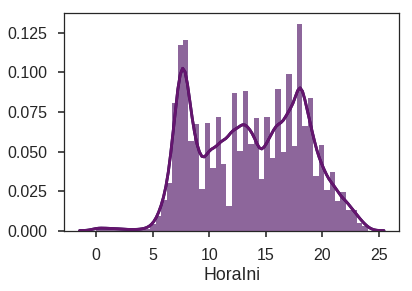

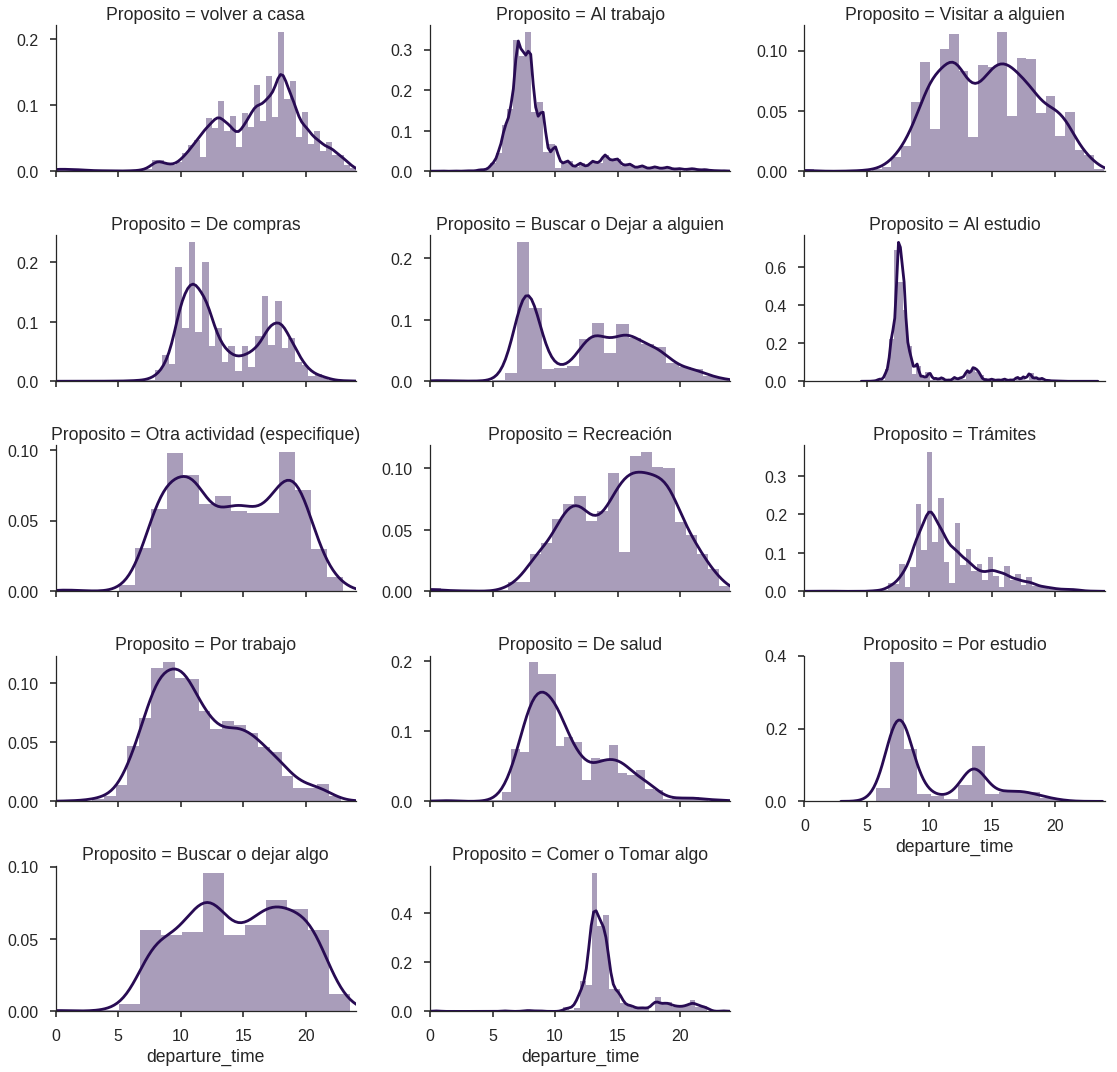

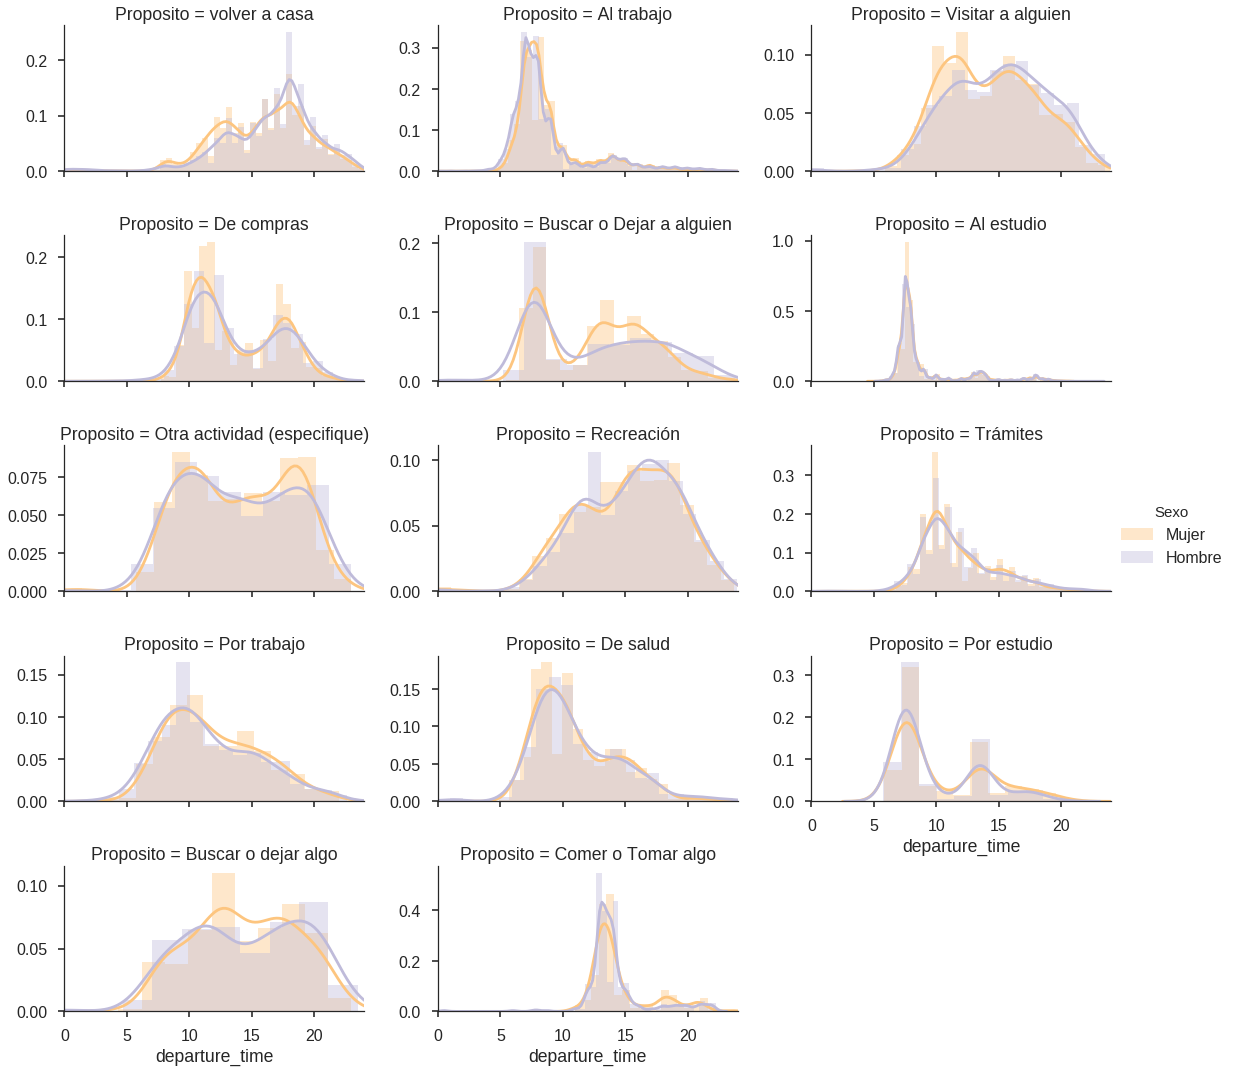

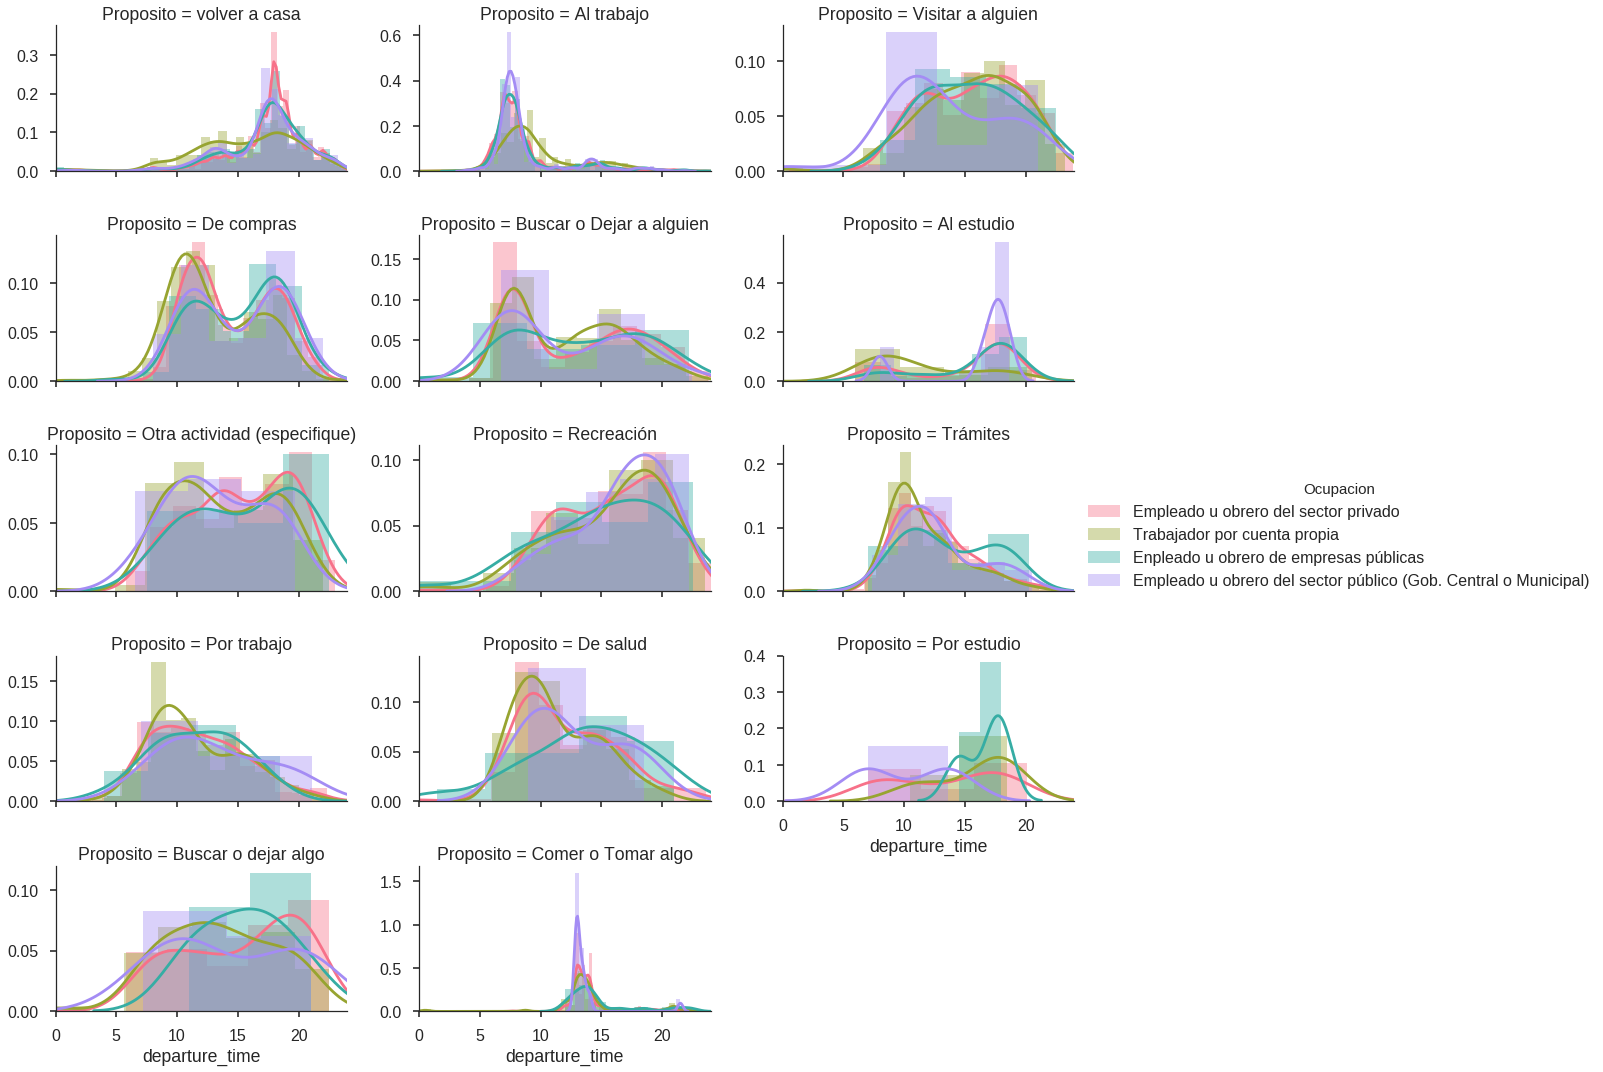

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Esto configura la apariencia de los gráficos utilizando configuraciones de seaborn
sns.set(context='poster', style='ticks', palette='inferno')

# Esto es una instrucción de Jupyter que hace que los gráficos se desplieguen en el notebook
%matplotlib inline

# la encuesta tiene tantas columnas que hacemos esto para imprimirlas todas
pd.set_option('max_columns', 1000)

trip_data = pd.read_csv('./carto-en-python/input/2012_eod_stgo/EOD_STGO/viajes.csv', sep=';')
trip_data.head()

trip_data.columns

municipalities = pd.read_csv('./carto-en-python/input/2012_eod_stgo/EOD_STGO/Tablas_parametros/Comuna.csv', sep=',')
municipalities.head()

trip_data.merge(municipalities, left_on='ComunaOrigen', right_on='Id').iloc[0]

def decode_column(df, fname, col_name, index_col='Id', target_col=None, value_col=None, sep=';', encoding='utf-8'):
    '''
    param :df: DataFrame del que leeremos una columna.
    param :fname: nombre del archivo que contiene los valores a decodificar.
    param :col_name: nombre de la columna que queremos decodificar.
    param :index_col: nombre de la columna en el archivo @fname que tiene los índices que codifican @col_name
    param :value_col: nombre de la columna en el archivo @fname que tiene los valores decodificados
    param :sep: carácter que separa los valores en @fname. 
    param :encoding: identificación del _character set_ que utiliza el archivo. Usualmente es utf-8, si no funciona,
                     se puede probar con iso-8859-1.
    '''
    if value_col is None:
        value_col = 'value'
        
    if target_col is None:
        target_col = col_name
        
    values_df = pd.read_csv(fname, sep=sep, index_col=index_col, names=[index_col, value_col], header=0,
                            dtype={index_col: np.float64}, encoding=encoding)
    
    src_df = df.loc[:,(col_name,)]
    
    return pd.Series(src_df.join(values_df, on=col_name)[value_col], name=target_col)

decode_column(trip_data.head(10), './carto-en-python/input/2012_eod_stgo/EOD_STGO/Tablas_parametros/Comuna.csv', 'ComunaOrigen', sep=',')

trip_data.MediosUsados.value_counts()

trip_mode = pd.read_csv('./carto-en-python/input/2012_eod_stgo/EOD_STGO/ViajesDifusion.csv', sep=';', index_col='Viaje')
trip_mode.head()

decode_column(trip_mode.sample(15), './carto-en-python/input/2012_eod_stgo/EOD_STGO/Tablas_parametros/ModoDifusion.csv', 'ModoDifusion', sep=';', index_col='ID', encoding='iso-8859-1')

trip_data.head().join(trip_mode)

trip_data = (pd.read_csv('./carto-en-python/input/2012_eod_stgo/EOD_STGO/viajes.csv', sep=';', index_col='Viaje')
             .assign(ComunaOrigen=lambda x: decode_column(x, './carto-en-python/input/2012_eod_stgo/EOD_STGO/Tablas_parametros/Comuna.csv', 'ComunaOrigen', sep=','))
             .assign(ComunaDestino=lambda x: decode_column(x, './carto-en-python/input/2012_eod_stgo/EOD_STGO/Tablas_parametros/Comuna.csv', 'ComunaDestino', sep=','))
             .assign(SectorOrigen=lambda x: decode_column(x, './carto-en-python/input/2012_eod_stgo/EOD_STGO/Tablas_parametros/Sector.csv', 'SectorOrigen', sep=';'))
             .assign(SectorDestino=lambda x: decode_column(x, './carto-en-python/input/2012_eod_stgo/EOD_STGO/Tablas_parametros/Sector.csv', 'SectorDestino', sep=';'))
             .join(pd.read_csv('./carto-en-python/input/2012_eod_stgo/EOD_STGO/ViajesDifusion.csv', sep=';', index_col='Viaje'))
             .assign(ModoDifusion=lambda x: decode_column(x, './carto-en-python/input/2012_eod_stgo/EOD_STGO/Tablas_parametros/ModoDifusion.csv', 'ModoDifusion', sep=';', index_col='ID', encoding='iso-8859-1'))
             .assign(Proposito=lambda x: decode_column(x, './carto-en-python/input/2012_eod_stgo/EOD_STGO/Tablas_parametros/Proposito.csv', 'Proposito', sep=';'))
             .join(pd.read_csv('./carto-en-python/input/2012_eod_stgo/EOD_STGO/DistanciaViaje.csv', sep=';', index_col='Viaje'))
            )

trip_data.sample(10)

trip_data = trip_data.dropna(subset=['HoraIni', 'HoraFin', 'SectorOrigen', 'SectorDestino', 'ComunaOrigen', 'ComunaDestino', 'Proposito', 'ModoDifusion'])

trip_data['HoraIni'] = trip_data.HoraIni.str.split(':').map(lambda x: pd.Timedelta(hours=int(x[0]), minutes=int(x[1])))
trip_data['HoraIni'].describe()

trip_data['HoraFin'] = trip_data.HoraFin.str.split(':').map(lambda x: pd.Timedelta(hours=int(x[0]), minutes=int(x[1])))
trip_data['HoraFin'].describe()

trip_data['HoraFin'][trip_data['HoraFin'] < trip_data['HoraIni']] = trip_data['HoraFin'][trip_data['HoraFin'] < trip_data['HoraIni']] + pd.Timedelta(days=1)

trip_data['departure_time'] = trip_data.HoraIni / pd.Timedelta(hours=1)

sns.distplot(trip_data.HoraIni / pd.Timedelta(hours=1))

sns.distplot(trip_data.HoraIni / pd.Timedelta(hours=1))

asdf = sns.FacetGrid(data=trip_data, col='Proposito', col_wrap=3, sharey=False, aspect=1.75, size=3)
asdf.map(sns.distplot, 'departure_time')
asdf.set(xlim=(0,24))

people_data = (pd.read_csv('./carto-en-python/input/2012_eod_stgo/EOD_STGO/personas.csv', sep=';', index_col='Persona')
               .assign(Sexo=lambda x: decode_column(x, './carto-en-python/input/2012_eod_stgo/EOD_STGO/Tablas_parametros/Sexo.csv', 'Sexo', sep=';'))
               .assign(Relacion=lambda x: decode_column(x, './carto-en-python/input/2012_eod_stgo/EOD_STGO/Tablas_parametros/Relacion.csv', 'Relacion', sep=';'))
               .assign(Ocupacion=lambda x: decode_column(x, './carto-en-python/input/2012_eod_stgo/EOD_STGO/Tablas_parametros/Ocupacion.csv', 'Ocupacion', sep=';'))
              )
people_data.head()

trip_data = trip_data.join(people_data.loc[:,('Sexo', 'Relacion', 'Ocupacion')], on='Persona')

g = sns.FacetGrid(data=trip_data, col='Proposito', hue='Sexo', col_wrap=3, sharey=False, aspect=1.75, size=3, palette='PuOr')
g.map(sns.distplot, 'departure_time')
g.set(xlim=(0,24))
g.add_legend()

ocupations = trip_data.Ocupacion.value_counts()
ocupations

g = sns.FacetGrid(data=trip_data, col='Proposito', hue='Ocupacion', col_wrap=3, sharey=False, aspect=1.75, size=3, palette='husl',
                 hue_order=ocupations.index[0:4])
g.map(sns.distplot, 'departure_time')
g.set(xlim=(0,24))
g.add_legend()

## Datos Geográficos

Recordemos la variable trip_data de la primera parte de este ejemplo práctico.


In [3]:
trip_data.head()

,Hogar,Persona,Etapas,ComunaOrigen,ComunaDestino,SectorOrigen,SectorDestino,ZonaOrigen,ZonaDestino,OrigenCoordX,OrigenCoordY,DestinoCoordX,DestinoCoordY,Proposito,PropositoAgregado,ActividadDestino,MediosUsados,ModoAgregado,ModoPriPub,ModoMotor,HoraIni,HoraFin,HoraMedia,TiempoViaje,TiempoMedio,Periodo,MinutosDespues,CuadrasDespues,FactorLaboralNormal,FactorSabadoNormal,FactorDomingoNormal,FactorLaboralEstival,FactorFindesemanaEstival,CodigoTiempo,ModoDifusion,DistEuclidiana,DistManhattan,Imputada,departure_time,Sexo,Relacion,Ocupacion
Viaje,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1734310202,173431,17343102,1,MAIPÚ,MAIPÚ,Poniente,Poniente,400,407,"335208,7188",6288387,"338812,3125",6292391,volver a casa,3.0,NaN,2,2,2,1,22:30:00,23:40:00,23:05,70.0,3.0,6.0,6.0,1.0,"1,00000000",NaN,NaN,NaN,NaN,0.0,Bip!,5387,7608,0,22.5,Mujer,Jefe(a) de Hogar,NaN
1734410101,173441,17344101,2,MAIPÚ,LAS CONDES,Poniente,Oriente,407,307,"338536,4375",6291928,"354267,3438",6302297,Al trabajo,1.0,5.0,2;4,9,2,1,13:00:00,14:45:00,13:53,105.0,4.0,5.0,5.0,1.0,"1,12721985",NaN,NaN,NaN,NaN,0.0,Bip!,18841,26100,0,13.0,Hombre,Otro pariente,Empleado u obrero del sector privado
1734410102,173441,17344101,2,LAS CONDES,MAIPÚ,Oriente,Poniente,307,407,"354267,3438",6302297,"338536,4375",6291928,volver a casa,1.0,NaN,4;2,9,2,1,22:00:00,23:30:00,22:45,90.0,3.0,5.0,10.0,2.0,"1,12721985",NaN,NaN,NaN,NaN,0.0,Bip!,18841,26100,0,22.0,Hombre,Otro pariente,Empleado u obrero del sector privado
1734410301,173441,17344103,2,MAIPÚ,ÑUÑOA,Poniente,Oriente,407,437,"338536,4375",6291928,"350841,6563",6297212,Al trabajo,1.0,5.0,2;4,9,2,1,09:00:00,09:55:00,9:27,55.0,2.0,5.0,10.0,2.0,"1,12721985",NaN,NaN,NaN,NaN,0.0,Bip!,13392,17589,0,9.0,Mujer,Jefe(a) de Hogar,Empleado u obrero del sector privado
1734410302,173441,17344103,2,ÑUÑOA,MAIPÚ,Oriente,Poniente,437,407,"350841,6563",6297212,"338536,4375",6291928,volver a casa,1.0,NaN,4;2,9,2,1,19:00:00,21:30:00,20:15,150.0,5.0,4.0,10.0,2.0,"1,05276356",NaN,NaN,NaN,NaN,0.0,Bip!,13392,17589,0,19.0,Mujer,Jefe(a) de Hogar,Empleado u obrero del sector privado



Vemos que la encuesta tiene coordenadas geográficas en las columnas OrigenCoord y DestinoCoord, con X e Y.

In [4]:
trip_data['OrigenCoordX'].head()

Viaje
1734310202    335208,7188
1734410101    338536,4375
1734410102    354267,3438
1734410301    338536,4375
1734410302    350841,6563
Name: OrigenCoordX, dtype: object

Usaremos el módulo `shapely` para trabajar con geometría y geografía, y el módulo `geopandas`, que esencialmente es `pandas` + geografía a través de `shapely`:

In [5]:
!apt install libspatialindex-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 3 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 1s (843 kB/s)
Selecting previously unselected package libspatialindex4v5:amd64.
(Reading database ... 22280 files and directories currently installed.)
Preparing to unpack .../libspatialindex4v5_1.8.5-5_am

In [6]:
!pip install shapely geopandas rtree

    100% |████████████████████████████████| 1.5MB 8.9MB/s 
    100% |████████████████████████████████| 901kB 15.4MB/s 
    100% |████████████████████████████████| 4.4MB 6.4MB/s 
    100% |████████████████████████████████| 17.8MB 1.6MB/s 
    100% |████████████████████████████████| 81kB 23.9MB/s 
  Running setup.py bdist_wheel for pyproj ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done
  Stored in directory: /root/.cache/pip/wheels/89/77/ec/a537585d1022dafde0317dd19d33c4a30d4ee61e19f25ebd8e
  Running setup.py bdist_wheel for munch ... - done
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159

In [7]:
!pip install descartes

In [0]:
from shapely.geometry import Point
import geopandas as gpd

In [10]:
trip_data['OrigenCoordX'] = trip_data.OrigenCoordX.str.replace(',', '.').astype(np.float)
trip_data['OrigenCoordX'].head()

Viaje
1734310202    335208.7188
1734410101    338536.4375
1734410102    354267.3438
1734410301    338536.4375
1734410302    350841.6563
Name: OrigenCoordX, dtype: float64

In [0]:
trip_data['OrigenCoordY'] = trip_data.OrigenCoordY.str.replace(',', '.').astype(np.float)
trip_data['DestinoCoordX'] = trip_data.DestinoCoordX.str.replace(',', '.').astype(np.float)
trip_data['DestinoCoordY'] = trip_data.DestinoCoordY.str.replace(',', '.').astype(np.float)

In [12]:
trip_data = trip_data.dropna(subset=['OrigenCoordX', 'OrigenCoordY', 'DestinoCoordX', 'DestinoCoordY'])
trip_data.shape

(89142, 42)

In [13]:
trip_data.head()

,Hogar,Persona,Etapas,ComunaOrigen,ComunaDestino,SectorOrigen,SectorDestino,ZonaOrigen,ZonaDestino,OrigenCoordX,OrigenCoordY,DestinoCoordX,DestinoCoordY,Proposito,PropositoAgregado,ActividadDestino,MediosUsados,ModoAgregado,ModoPriPub,ModoMotor,HoraIni,HoraFin,HoraMedia,TiempoViaje,TiempoMedio,Periodo,MinutosDespues,CuadrasDespues,FactorLaboralNormal,FactorSabadoNormal,FactorDomingoNormal,FactorLaboralEstival,FactorFindesemanaEstival,CodigoTiempo,ModoDifusion,DistEuclidiana,DistManhattan,Imputada,departure_time,Sexo,Relacion,Ocupacion
Viaje,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1734310202,173431,17343102,1,MAIPÚ,MAIPÚ,Poniente,Poniente,400,407,335208.7188,6288387.0,338812.3125,6292391.0,volver a casa,3.0,NaN,2,2,2,1,22:30:00,23:40:00,23:05,70.0,3.0,6.0,6.0,1.0,"1,00000000",NaN,NaN,NaN,NaN,0.0,Bip!,5387,7608,0,22.5,Mujer,Jefe(a) de Hogar,NaN
1734410101,173441,17344101,2,MAIPÚ,LAS CONDES,Poniente,Oriente,407,307,338536.4375,6291928.0,354267.3438,6302297.0,Al trabajo,1.0,5.0,2;4,9,2,1,13:00:00,14:45:00,13:53,105.0,4.0,5.0,5.0,1.0,"1,12721985",NaN,NaN,NaN,NaN,0.0,Bip!,18841,26100,0,13.0,Hombre,Otro pariente,Empleado u obrero del sector privado
1734410102,173441,17344101,2,LAS CONDES,MAIPÚ,Oriente,Poniente,307,407,354267.3438,6302297.0,338536.4375,6291928.0,volver a casa,1.0,NaN,4;2,9,2,1,22:00:00,23:30:00,22:45,90.0,3.0,5.0,10.0,2.0,"1,12721985",NaN,NaN,NaN,NaN,0.0,Bip!,18841,26100,0,22.0,Hombre,Otro pariente,Empleado u obrero del sector privado
1734410301,173441,17344103,2,MAIPÚ,ÑUÑOA,Poniente,Oriente,407,437,338536.4375,6291928.0,350841.6563,6297212.0,Al trabajo,1.0,5.0,2;4,9,2,1,09:00:00,09:55:00,9:27,55.0,2.0,5.0,10.0,2.0,"1,12721985",NaN,NaN,NaN,NaN,0.0,Bip!,13392,17589,0,9.0,Mujer,Jefe(a) de Hogar,Empleado u obrero del sector privado
1734410302,173441,17344103,2,ÑUÑOA,MAIPÚ,Oriente,Poniente,437,407,350841.6563,6297212.0,338536.4375,6291928.0,volver a casa,1.0,NaN,4;2,9,2,1,19:00:00,21:30:00,20:15,150.0,5.0,4.0,10.0,2.0,"1,05276356",NaN,NaN,NaN,NaN,0.0,Bip!,13392,17589,0,19.0,Mujer,Jefe(a) de Hogar,Empleado u obrero del sector privado


In [14]:
def to_point(row, prefix='OrigenCoord'):
    return Point(row[prefix + 'X'], row[prefix + 'Y'])

trip_data.sample(5).apply(to_point, axis=1)

Viaje
1405810101      POINT (352821.0938 6288956)
1481400201     POINT (349694.875 6281891.5)
1270830102    POINT (337377.9688 6305654.5)
2685820102     POINT (349433.875 6299443.5)
1625710101    POINT (356670.3438 6311456.5)
dtype: object

In [15]:
trip_data['origin'] = trip_data.apply(lambda x: to_point(x, 'OrigenCoord'), axis=1)
trip_data['destination'] = trip_data.apply(lambda x: to_point(x, 'DestinoCoord'), axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Aquí creamos un "GeoDataFrame" utilizando lo que hemos construido hasta el momento. Haremos uno para los orígenes de los viajes y otro para los destinos.

In [0]:
origins = gpd.GeoDataFrame(trip_data.copy(), geometry='origin', crs={'init': 'epsg:5361'})
destinations = gpd.GeoDataFrame(trip_data.copy(), geometry='destination', crs={'init': 'epsg:5361'})

Una conveniencia de usar geopandas es que permite visualizar fácilmente lo que tenemos en el geodataframe:

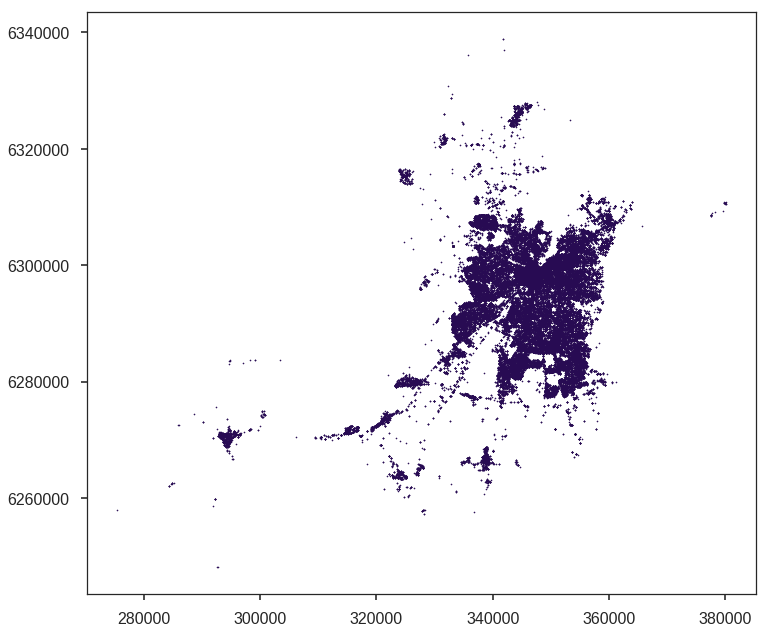

In [17]:
origins.plot(figsize=(12,12), marker='.', markersize=5)

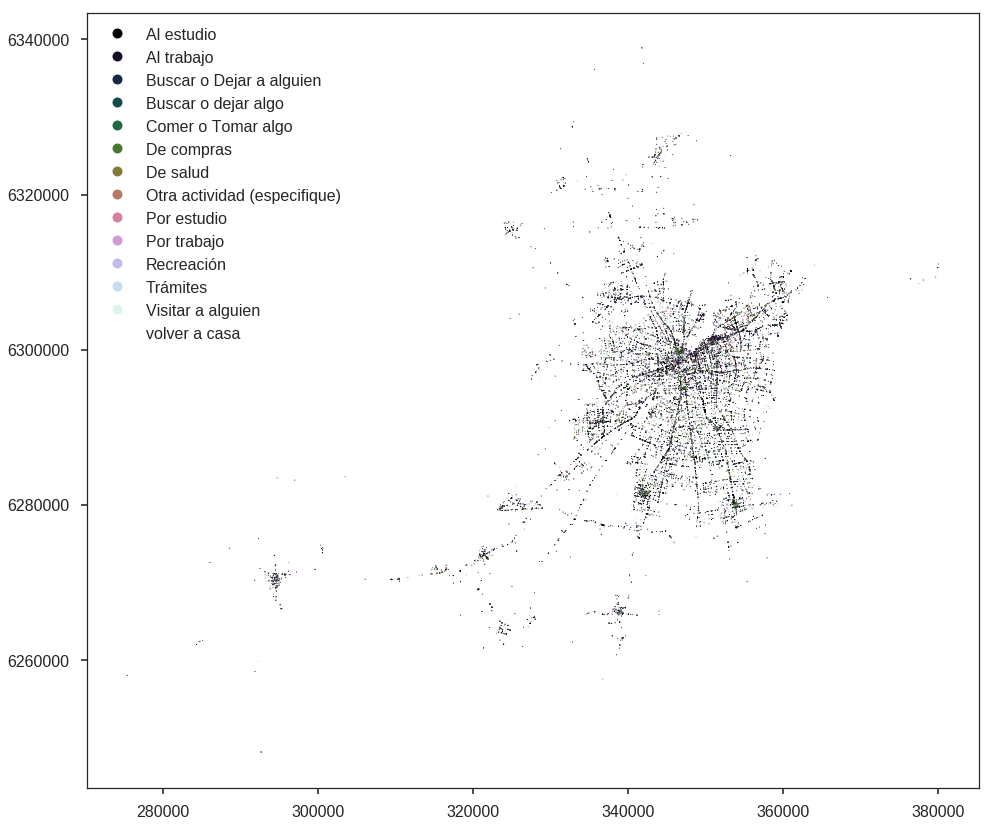

In [18]:
destinations.plot(column='Proposito', categorical=True, figsize=(16,16), marker='.', markersize=1, legend=True, cmap='cubehelix')

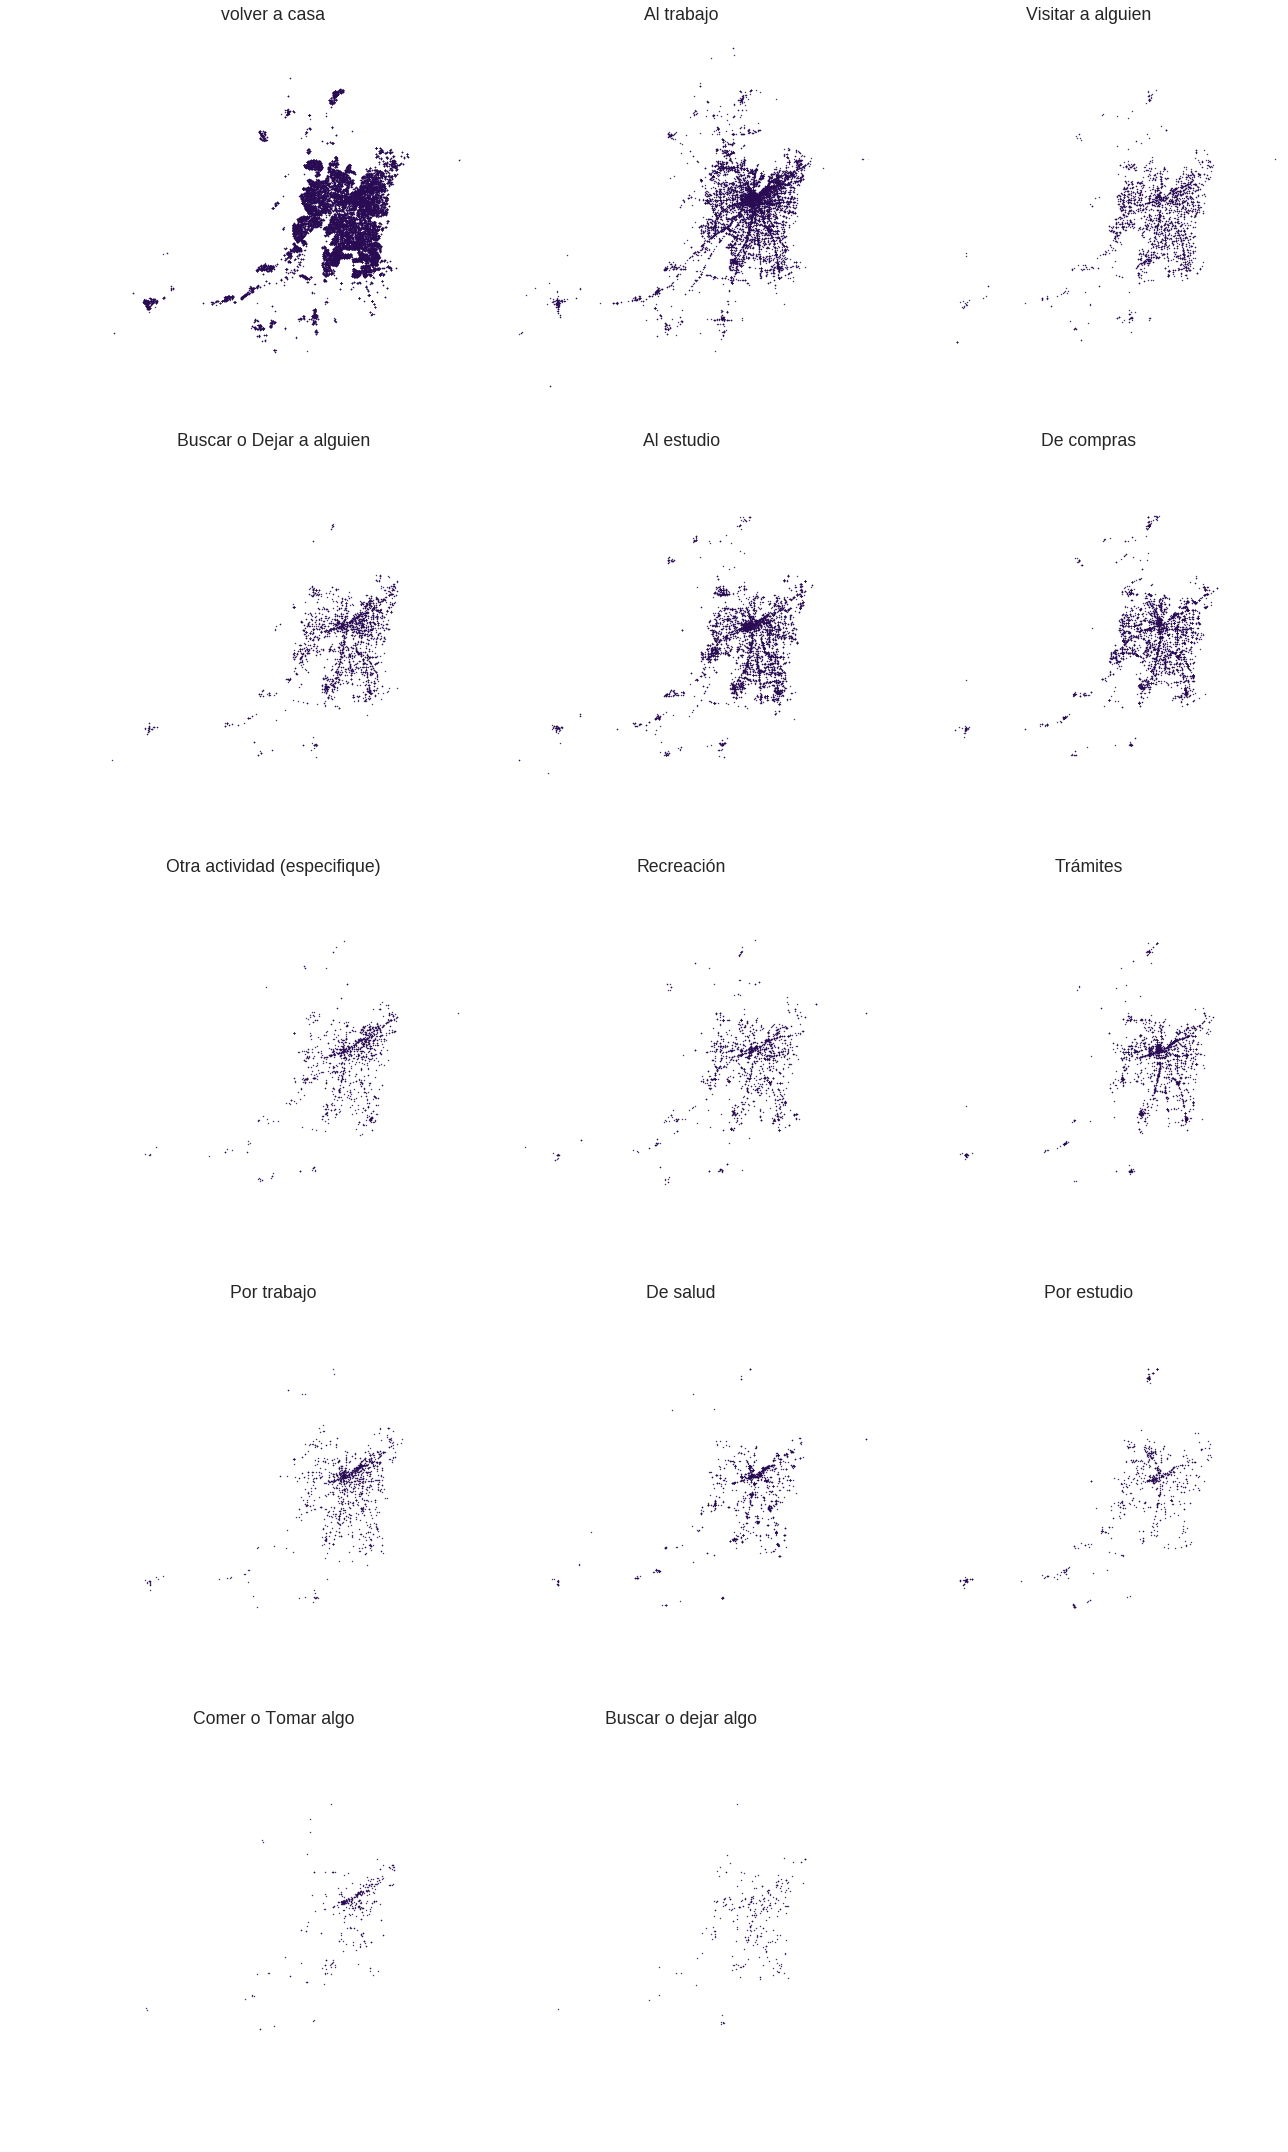

In [19]:
def plot_points(**kwargs):
    ax = plt.gca()
    
    geodf = kwargs.pop('data')
    color = kwargs.pop('color', None)

    geodf.plot(ax=ax, 
               categorical=kwargs.pop('categorical', True), 
               markersize=kwargs.pop('markersize', 5),
               alpha=kwargs.pop('alpha', 1),
               color=color)
    
    plt.axis('equal')
    plt.axis('off')
    
g = sns.FacetGrid(data=destinations, col='Proposito', col_wrap=3,
                  size=6, dropna=False, palette='viridis')

g.map_dataframe(plot_points, categorical=True, markersize=1, alpha=0.75)
g.set_titles('{col_name}')

Podemos utilizar otras funciones, como la Kernel Density Estimation en 2D:

/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'cbar', 'cbar_kws'
  s)


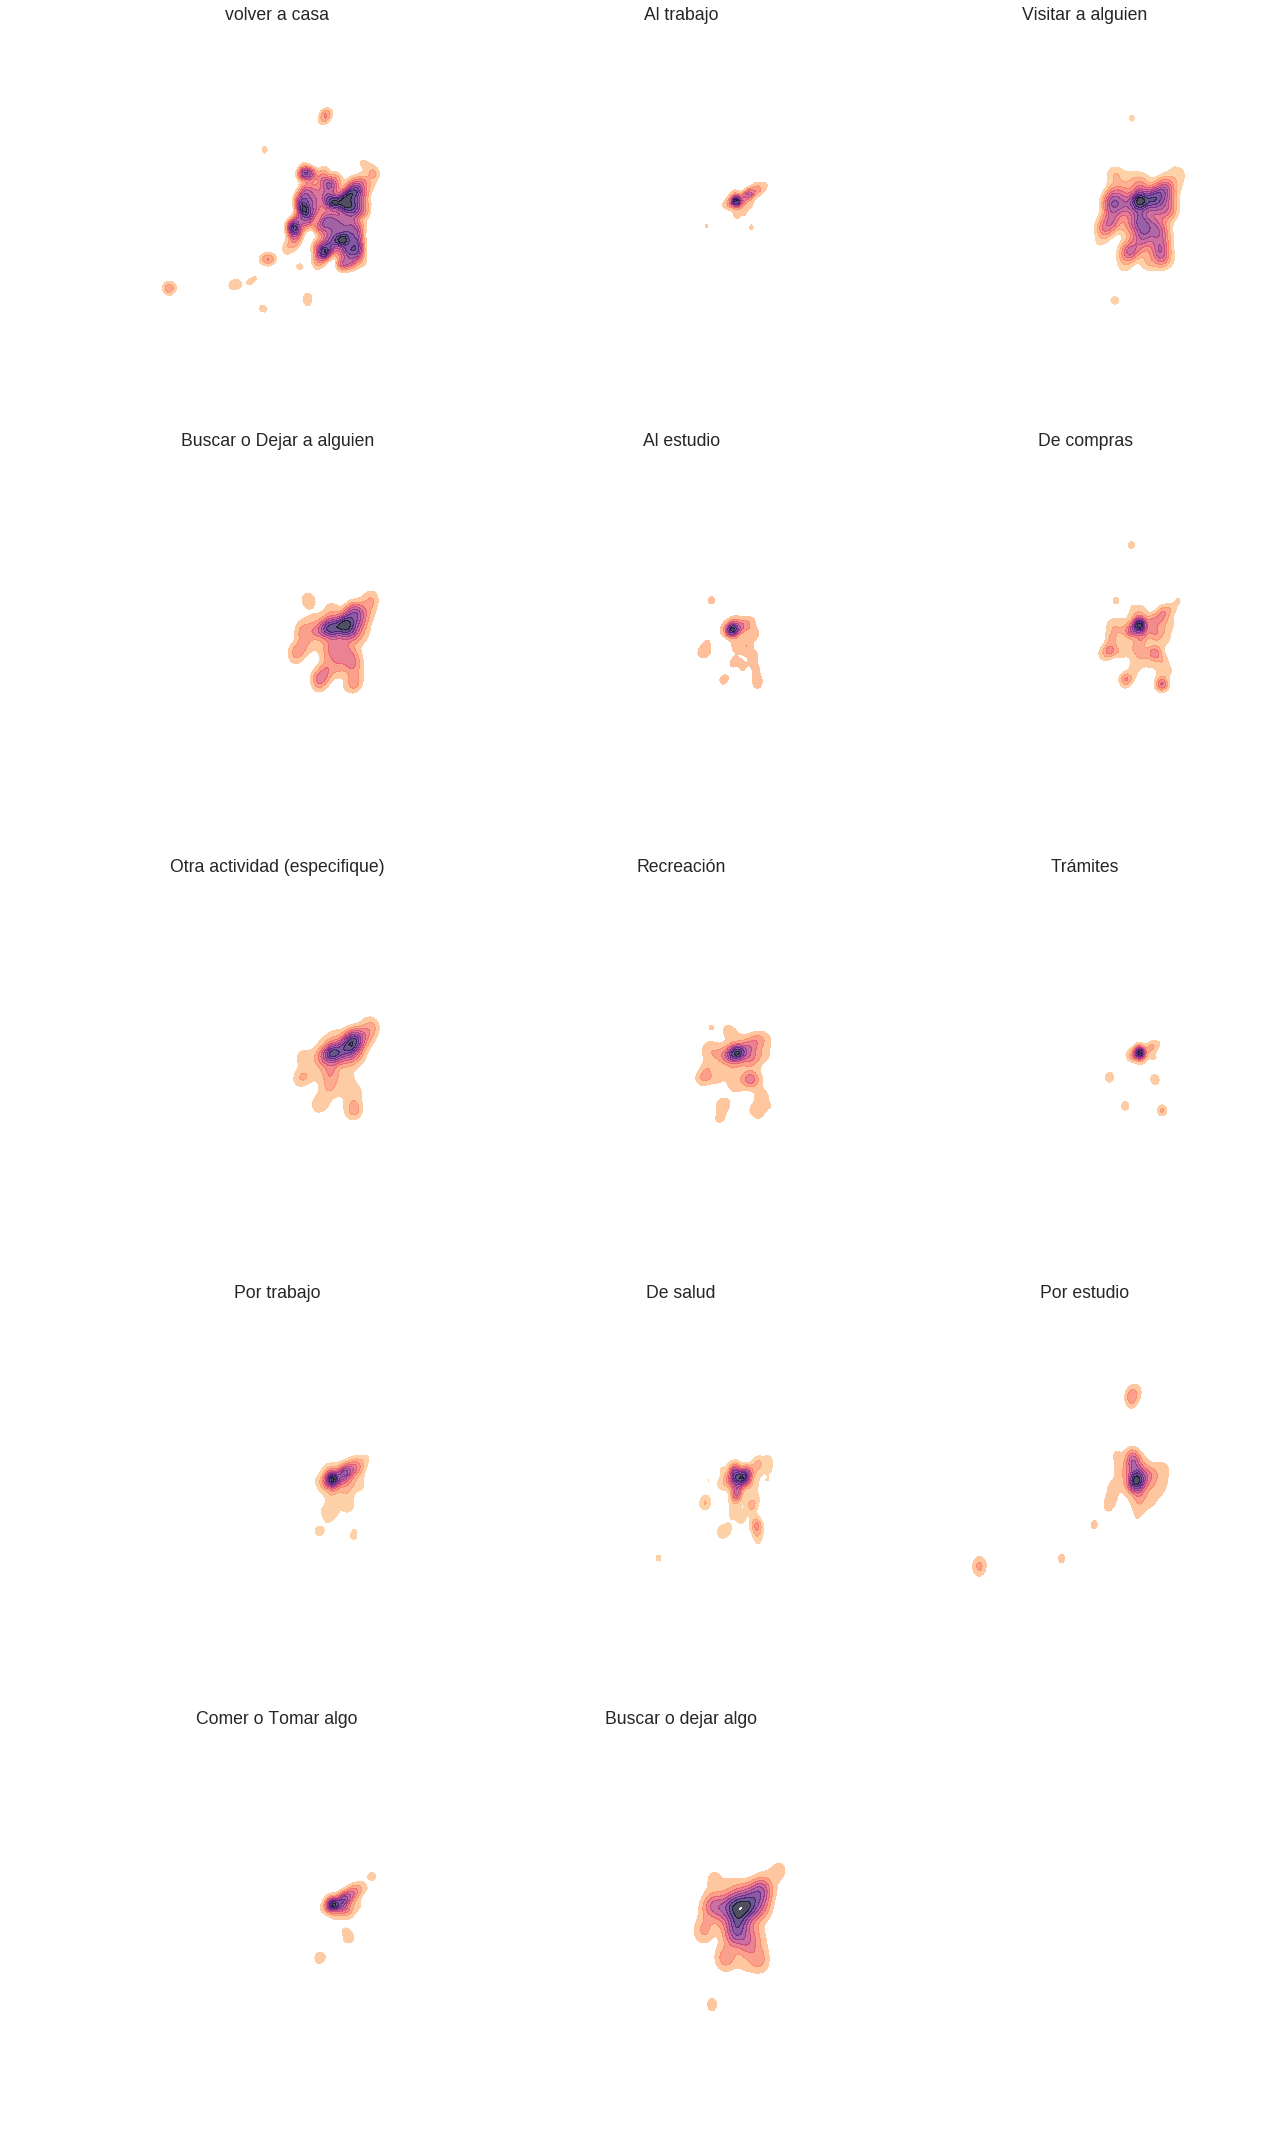

In [20]:
def plot_point_distribution(**kwargs):
    ax = plt.gca()

    color = kwargs.pop('color')
    geodf = kwargs.pop('data')
    bounds = kwargs.pop('bounds', None)

    sns.kdeplot(geodf.geometry.x, geodf.geometry.y, **kwargs)

    if bounds is not None:
        plt.xlim(bounds[:,0])
        plt.ylim(bounds[:,1])
    
    plt.axis('equal')
    plt.axis('off')

    
g = sns.FacetGrid(data=destinations, col='Proposito', col_wrap=3, size=6, dropna=False)
g.map_dataframe(plot_point_distribution, shade=True, alpha=0.7, cbar=True, cmap='magma_r',
                #clip=bounds,
                shade_lowest=False,
                cbar_kws={'orientation': 'horizontal', 
                         #'label': '# de Viajes',
                         'fraction': 0.02, 
                         'shrink': 0.35,
                         'pad': 0})
g.set_titles('{col_name}')
g.fig.tight_layout()

Esto es genial, pero solamente dibujando puntos y áreas nos cuesta ver lo que está sucediendo. Necesitamos más contexto.
Para eso cargaremos datos auxiliares que visualizaremos junto con los resultados anteriores.

Un formato típico con el que trabajan en geografía son los Shapefiles. Afortunadamente, geopandas permite cargar shapefiles de manera muy sencilla:

In [21]:
municipalities = (gpd.read_file('./carto-en-python/input/shapefile_comunas', crs={'init': 'epsg:5361'})
                  .pipe(lambda x: x[x['NOM_REG'] == 'Región Metropolitana de Santiago'].copy())
                 )
municipalities.head()

,NOM_REG,NOM_PROV,NOM_COM,SHAPE_LENG,DIS_ELEC,CIR_SENA,COD_COMUNA,SHAPE_Le_1,SHAPE_Area,geometry
175,Región Metropolitana de Santiago,Melipilla,María Pinto,109727.643978,31,7,1350,109727.644651,3.945066e+08,"POLYGON ((289232.6409 6300952.7679, 289309.948..."
176,Región Metropolitana de Santiago,Melipilla,San Pedro,162648.311900,31,7,1350,162648.311142,7.938374e+08,"POLYGON ((264887.7618000004 6261097.7703, 2649..."
177,Región Metropolitana de Santiago,Santiago,Independencia,11488.695747,19,7,1310,11718.687086,7.514746e+06,"POLYGON ((345884.0031000003 6302609.6842, 3458..."
178,Región Metropolitana de Santiago,Santiago,La Florida,49696.426793,26,8,1311,49621.402175,7.103733e+07,"POLYGON ((366277.2295000004 6293233.7903, 3663..."
179,Región Metropolitana de Santiago,Santiago,Lo Barnechea,149539.074262,23,8,1311,149865.511039,1.024735e+09,"POLYGON ((362574.8693000004 6306774.1648, 3626..."


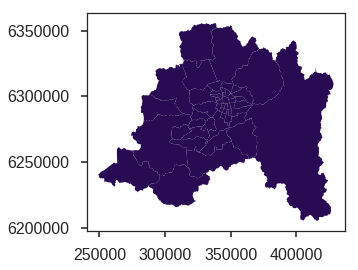

In [22]:
municipalities.plot()


In [0]:
def plot_context(ax):
    municipalities.plot(edgecolor='black', facecolor='#efefef', ax=ax)

Y digamos que solamente nos interesan los viajes en el área urbana de la ciudad.

In [25]:
trip_data.SectorOrigen.value_counts()

Oriente                   19097
Poniente                  15693
Sur-Oriente               14733
Sur                       14545
Norte                     10976
Centro                     9317
Extensión Sur-Poniente     4781
Name: SectorOrigen, dtype: int64

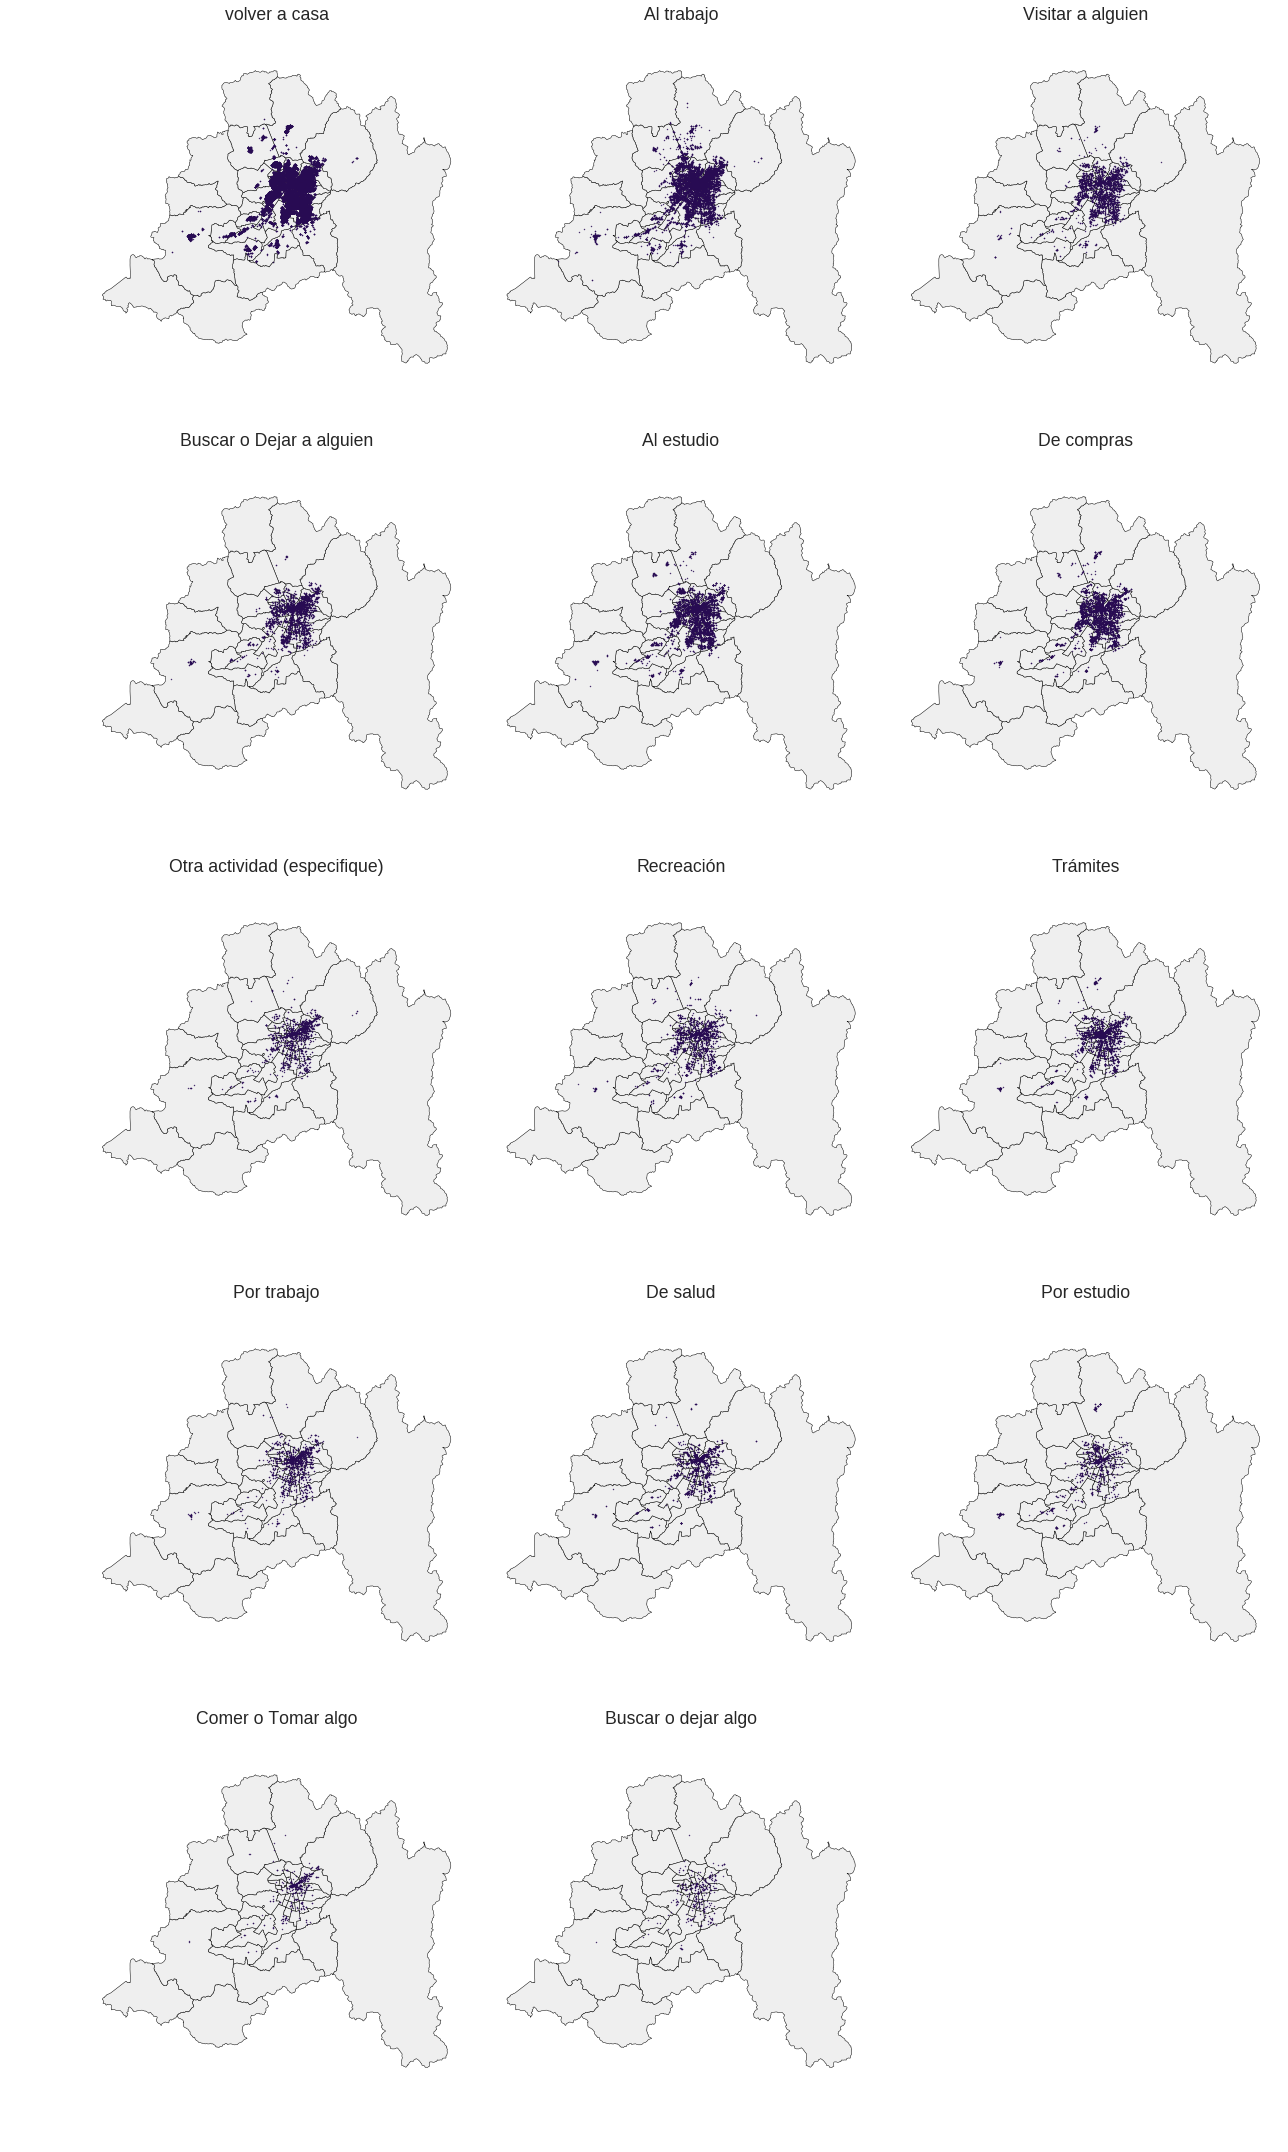

In [26]:
def plot_points(**kwargs):
    ax = plt.gca()
    
    # context!
    context_func = kwargs.pop('context', None)
    if context_func:
        context_func(ax=ax)
    
    geodf = kwargs.pop('data')
    color = kwargs.pop('color', None)

    geodf.plot(ax=ax, 
               categorical=kwargs.pop('categorical', True), 
               markersize=kwargs.pop('markersize', 5),
               alpha=kwargs.pop('alpha', 1),
               color=color)
    
    plt.axis('equal')
    plt.axis('off')
    
g = sns.FacetGrid(data=destinations, col='Proposito', col_wrap=3,
                  size=6, dropna=False, palette='viridis')

g.map_dataframe(plot_points, context=plot_context, categorical=True, markersize=1, alpha=0.75)
g.set_titles('{col_name}')

Necesitamos otro shapefile que nos permita definir un área bajo estudio. Afortunadamente existe uno :)

In [27]:
urban_areas = gpd.read_file('./carto-en-python/input/urban_areas/', crs={'init': 'epsg:5361'})
urban_areas.head()

,NOMBRE,TIPO_AREA,SHAPE_Leng,SHAPE_Area,geometry
0,Chiguayante,Ciudad,29855.998337,1.038076e+07,"POLYGON ((140044.6339999996 5911024.2843, 1400..."
1,Lota,Ciudad,14233.349738,5.262642e+06,"POLYGON ((131359.6661999999 5889462.9023, 1314..."
2,Coronel,Ciudad,41577.791832,1.551685e+07,"POLYGON ((127278.4398999996 5896965.4356, 1274..."
3,San Rosendo,Ciudad,6499.369423,1.534402e+06,"POLYGON ((168583.8304000003 5870293.9702, 1687..."
4,Concepción,Ciudad,82986.894378,3.454227e+07,"POLYGON ((133504.8541999999 5919782.2124, 1360..."


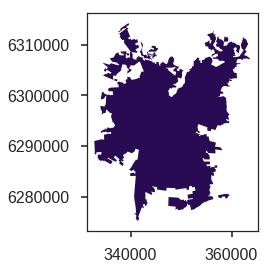

In [28]:
urban_areas[urban_areas.NOMBRE == 'Santiago'].plot()

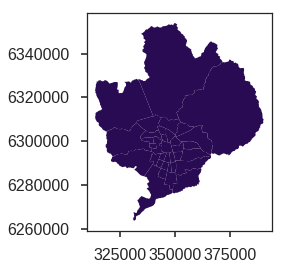

In [29]:
stgo_municipalities = gpd.sjoin(municipalities, urban_areas[urban_areas.NOMBRE == 'Santiago'], op='intersects')
stgo_municipalities.plot()

Aquí utilizamos operaciones de shapely de bajo nivel.

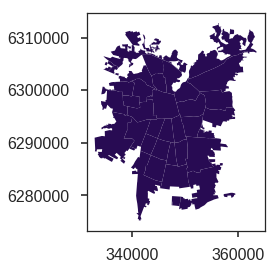

In [30]:
def urban_part(municipality):
    return municipality.intersection(urban_areas[urban_areas.NOMBRE == 'Santiago'].geometry.values[0])

stgo_urban = (stgo_municipalities.copy()
              .assign(geometry=lambda df_: df_['geometry'].map(urban_part))
              .pipe(lambda x: x[~x.NOM_COM.isin(['Lampa', 'Colina'])])
              .drop(['SHAPE_Leng', 'SHAPE_Area_right', 'index_right', 'NOMBRE', 'TIPO_AREA'], axis=1))
stgo_urban.plot()

El siguiente paso es quedarnos solamente con los viajes que están dentro de esta área.

In [31]:
stgo_urban.head()

,NOM_REG,NOM_PROV,NOM_COM,SHAPE_LENG,DIS_ELEC,CIR_SENA,COD_COMUNA,SHAPE_Le_1,SHAPE_Area_left,geometry
177,Región Metropolitana de Santiago,Santiago,Independencia,11488.695747,19,7,1310,11718.687086,7.514746e+06,"POLYGON ((345884.0031000003 6302609.6842, 3458..."
178,Región Metropolitana de Santiago,Santiago,La Florida,49696.426793,26,8,1311,49621.402175,7.103733e+07,"POLYGON ((355737.3829907289 6286882.946599475,..."
179,Región Metropolitana de Santiago,Santiago,Lo Barnechea,149539.074262,23,8,1311,149865.511039,1.024735e+09,"(POLYGON ((362193.352993806 6307218.971546588,..."
180,Región Metropolitana de Santiago,Santiago,Lo Espejo,11405.976039,28,8,1311,11389.045242,8.181655e+06,"POLYGON ((342637.7674000002 6291726.7842, 3427..."
181,Región Metropolitana de Santiago,Santiago,Lo Prado,10795.433316,18,7,1311,10691.672491,6.535088e+06,"POLYGON ((341488.7580000004 6296729.4443, 3414..."


/usr/local/lib/python3.6/dist-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


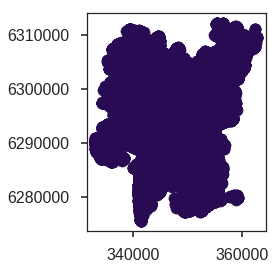

In [32]:
urban_origins = gpd.sjoin(origins, stgo_urban, op='within', how='inner')
urban_origins.plot()

/usr/local/lib/python3.6/dist-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


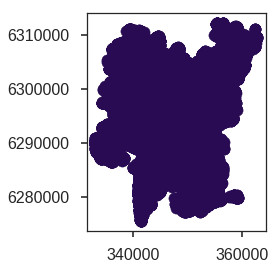

In [33]:
urban_destinations = gpd.sjoin(destinations, stgo_urban, op='within', how='inner')
urban_destinations.plot()

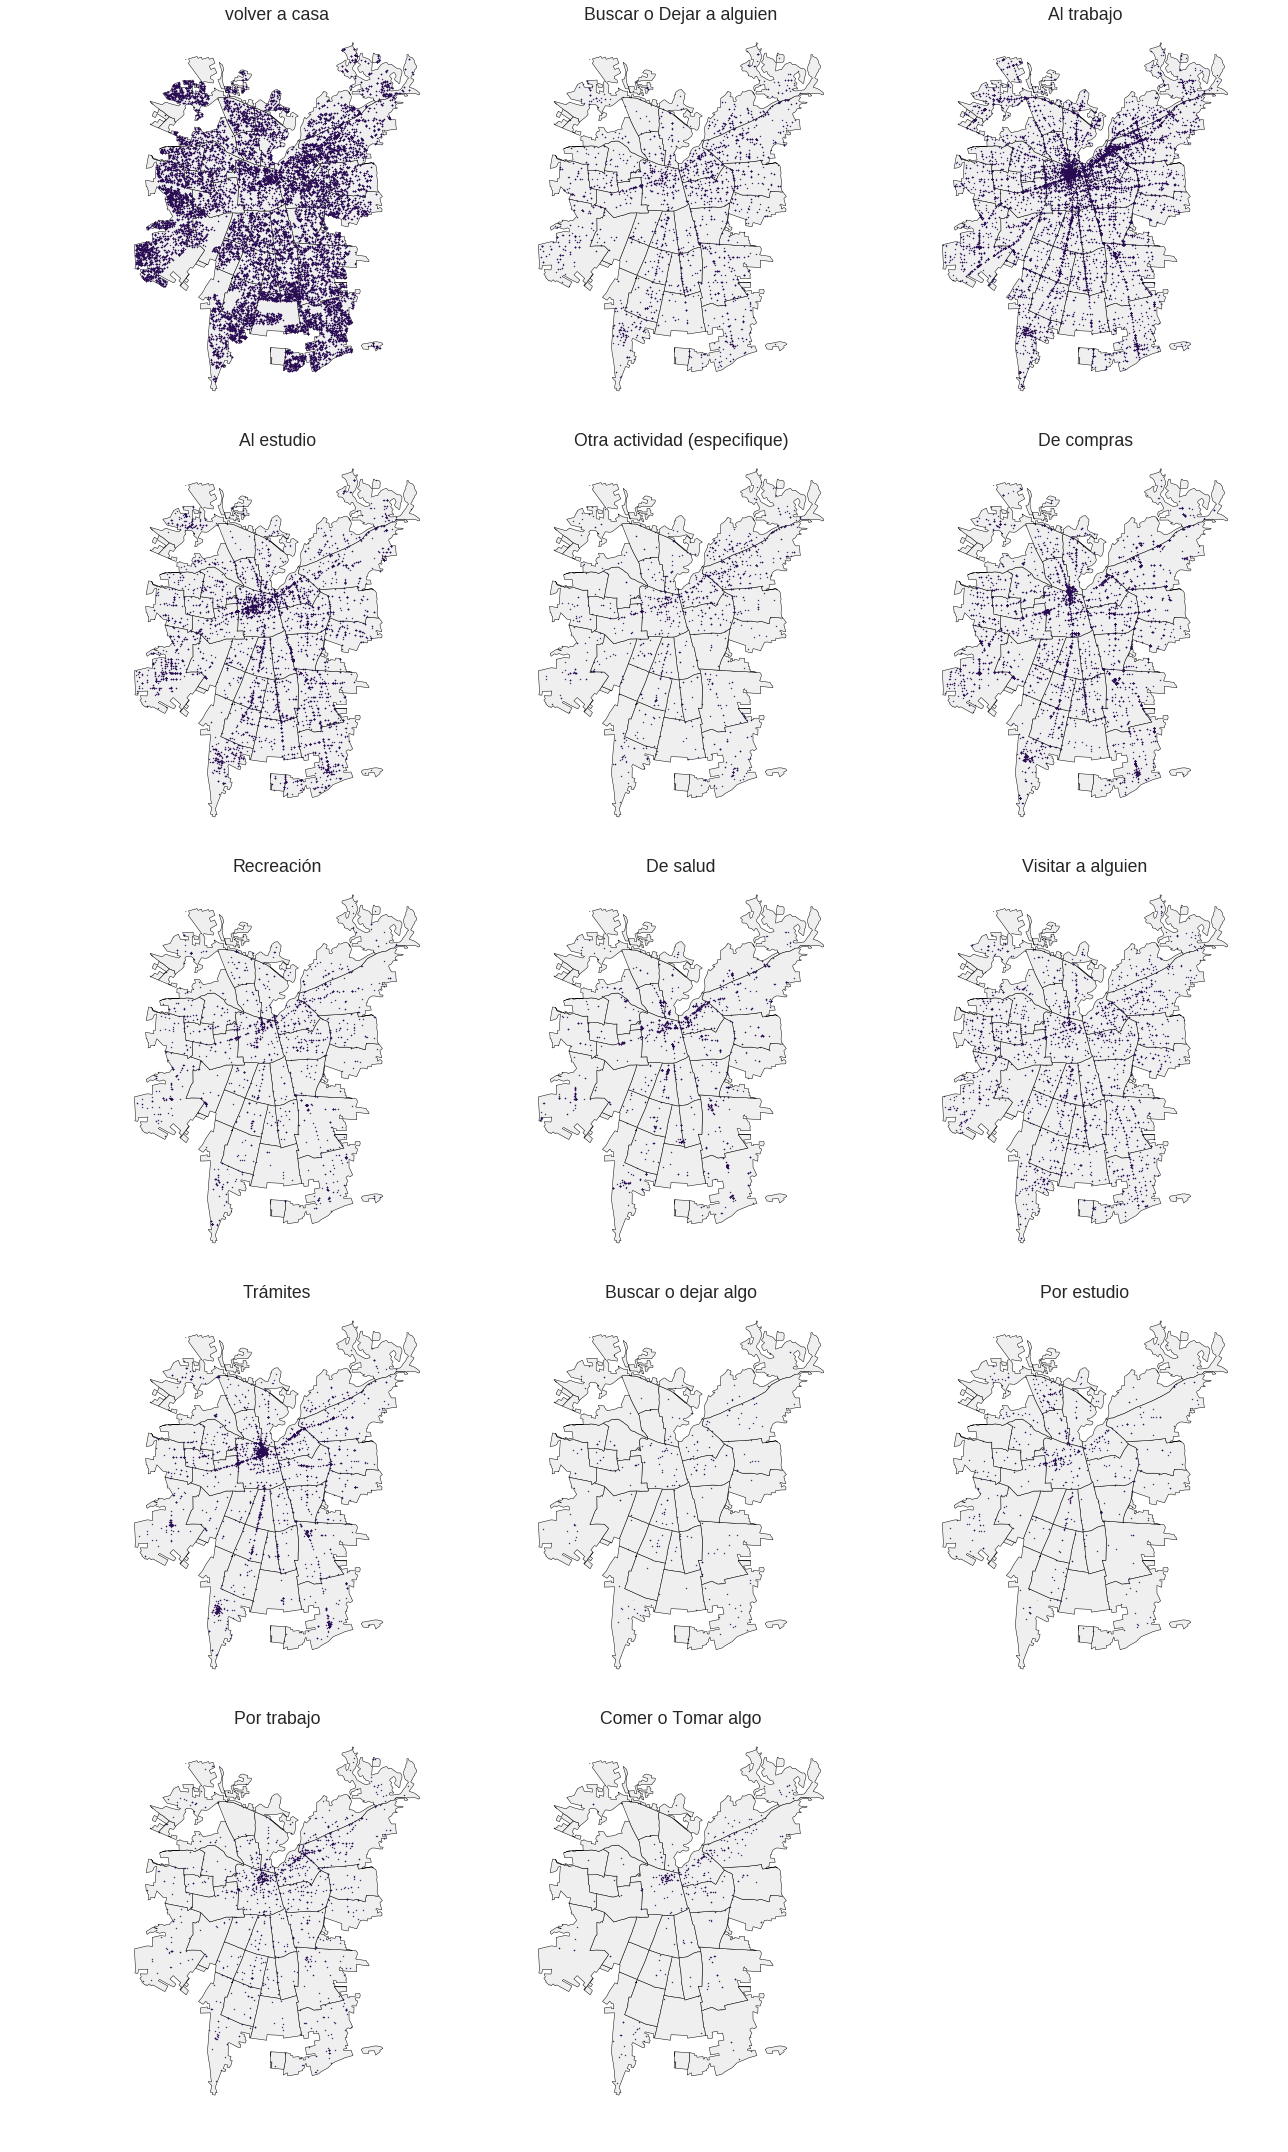

In [34]:
def plot_context(ax):
    stgo_urban.plot(edgecolor='black', facecolor='#efefef', ax=ax)
     
g = sns.FacetGrid(data=urban_destinations, col='Proposito', col_wrap=3,
                  size=6, dropna=False, palette='viridis')

g.map_dataframe(plot_points, context=plot_context, categorical=True, markersize=1, alpha=0.75)
g.set_titles('{col_name}')